In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
import numpy as np
import diffprivlib  as dp
import matplotlib.pyplot as plt



## 1) Estimating the Epsilon

##### Implementing the Econmic method from Hsu et al.
[J. Hsu et al., "Differential Privacy: An Economic Method for Choosing Epsilon," 2014 IEEE 27th Computer Security Foundations Symposium, Vienna, 2014, pp. 398-410.](https://arxiv.org/pdf/1402.3329.pdf)


https://www.cis.upenn.edu/~ahae/talks/epsilon-csf2014.pdf


<figure>
<img src="images/hsu-et-al-equation7.PNG" />
</figure>


<figure>
<img src="images/hsu-et-al-equation8.PNG"  />
</figure>


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


B =10000#budget
alpha=0.02#probability
T=0.08#additive error  +- 8%
average_breach_chance=0.08
average_breach_cost_US=429
E_Patient_Expected_US=average_breach_cost_US*average_breach_chance
study_feasable_func = lambda E: np.log( 1+ ((B*pow(T,2))/(12*E*np.log(3/alpha))) )-(T/6)
initial_guess = 0.01
E_feasiable = fsolve(study_feasable_func, initial_guess)

print('Particpants\' belief on the average cost even if they dont attend: '+str(E_Patient_Expected_US))
print ('Feasiable cost per particpant based on our budget: '+str(E_feasiable))
print('Is it feasible?'+str(E_feasiable>E_Patient_Expected_US))

Particpants' belief on the average cost even if they dont attend: 34.32
Feasiable cost per particpant based on our budget: [79.29917783]
Is it feasible?[ True]


In [4]:
N=(12/pow(T,2))*np.log(3/alpha)
print('Number of particpants: '+str(int(N+0.5)))


Number of particpants: 9395


In [5]:
total_epsilon_budget=T/6
print ('Epsilon Value: '+ str(total_epsilon_budget))

Epsilon Value: 0.013333333333333334


In [6]:
# total_epsilon_budget=0.1

## 2) Load and Preprocess Data

In [7]:
ecg_file_input_path='/Users/aring/jupyter/differential-privacy/data/Arno/Diagnostics.xlsx'
ecg_df=pd.read_excel(ecg_file_input_path)
ecg_df.head()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,01-01-1932,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,01-01-1958,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,01-01-1996,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,01-01-1951,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,01-01-1943,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [8]:
ecg_df.shape

(10646, 17)

In [9]:
Y_df=ecg_df['Rhythm']


In [10]:
arrhytmia_types=Y_df.unique()
arrhytmia_types

array(['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT',
       'SAAWR', 'AVRT'], dtype=object)

## 3) Train Classifier

### 3.1) prepare inout data

In [11]:
from sklearn import preprocessing

labelEncoder = preprocessing.LabelEncoder();
encoded_y=labelEncoder.fit_transform(Y_df)

In [12]:
ecg_df.drop(['DateofBirth'], axis=1,inplace=True)
ecg_df.drop(['Beat'], axis=1,inplace=True)
ecg_df.drop(['FileName'], axis=1,inplace=True)
ecg_df.drop(['Rhythm'], axis=1,inplace=True)


In [13]:
ecg_df['Gender_encoded']=ecg_df['Gender'].map({'MALE':0,'FEMALE':1})


In [14]:
gender_df=ecg_df['Gender_encoded']
ecg_df.drop(['Gender'], axis=1,inplace=True)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(ecg_df, encoded_y, test_size=0.2)

### 3.2  Calculate ranges/bounds for columns

In [16]:
col_names=ecg_df.columns
ranges_min=[]
ranges_max=[]
bounds_for_forest={}
for i in range(len(col_names)):
    min_val=ecg_df[ecg_df.columns[i]].min()
    max_val=ecg_df[ecg_df.columns[i]].max()
    ranges_min.append(min_val)
    ranges_max.append(max_val)
    bounds_for_forest[col_names[i]]=[min_val,max_val]

bounds = (ranges_min,ranges_max )

In [17]:
bounds

([4, 34, 0, 18, 114, 219, -89, -89, 5, 159, 249, 281, 0],
 [98, 263, 535, 256, 736, 760, 270, 270, 40, 240, 331, 582, 1])

In [18]:
bounds_for_forest

{'PatientAge': [4, 98],
 'VentricularRate': [34, 263],
 'AtrialRate': [0, 535],
 'QRSDuration': [18, 256],
 'QTInterval': [114, 736],
 'QTCorrected': [219, 760],
 'RAxis': [-89, 270],
 'TAxis': [-89, 270],
 'QRSCount': [5, 40],
 'QOnset': [159, 240],
 'QOffset': [249, 331],
 'TOffset': [281, 582],
 'Gender_encoded': [0, 1]}

### 3.3 Train Naive Bayes Classifier Using Cross validation

In [19]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [20]:
#non-difpriv model
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from numpy import mean,std

cv = KFold(n_splits=10, random_state=1, shuffle=True)
clf = GaussianNB()

# evaluate model
scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.742 (0.025)


In [21]:
#diff priv model with epsilon 1
from diffprivlib.models import GaussianNB


    
clf = GaussianNB(bounds=bounds,epsilon=100)
# evaluate model
scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.749 (0.018)


#### 3.3.1) Accuracy of the model across  different epsilon values

In [22]:
col_names=ecg_df.columns
ranges_min=[]
ranges_max=[]
for i in range(len(col_names)):
    ranges_min.append(ecg_df[ecg_df.columns[i]].min())
    ranges_max.append(ecg_df[ecg_df.columns[i]].max())

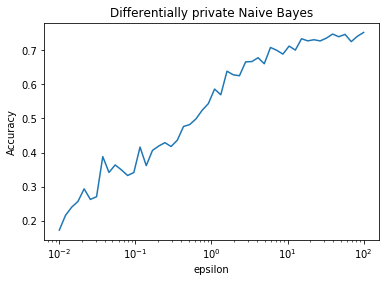

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB

epsilons = np.logspace(-2, 2, 50)
bounds = (ranges_min,ranges_max )
accuracy = list()

for epsilon in epsilons:
    clf = GaussianNB(bounds=bounds, epsilon=epsilon)
    scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)    
    accuracy.append(mean(scores))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private Naive Bayes")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()

### 3.4) Train Logistic Regression Classifier Using Cross validation

In [24]:
import diffprivlib as dp
import numpy as np
from sklearn.linear_model import LogisticRegression

In [25]:

#non-difpriv model
cv = KFold(n_splits=10, random_state=1, shuffle=True)
clf = LogisticRegression()
scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.758 (0.014)


In [26]:
#diff priv model

In [27]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
dp_clf = dp.models.LogisticRegression(epsilon = 100)
scores = cross_val_score(dp_clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: 0.639 (0.035)


Differntially private LogisticRegression has a data_norm parameter defines the spread of data that will be protected by differential privacy. If not specified, the max norm is taken from the data during the fit operation but will result in revealing information about the data.  The value for data_norm should be selected using the domain knowledge independently of the data.  The model will clipall the examples to have a 2-norm of at most data_norm specified.

In [28]:
#checking l2 norm in our data
l2_of_all_rows=np.apply_along_axis(np.linalg.norm, 1, ecg_df)
print('l2 of dataframe: %.3f (%.3f)' % (mean(l2_of_all_rows), std(l2_of_all_rows)))
print('max/min l2: %.3f (%.3f)' % (max(l2_of_all_rows), min(l2_of_all_rows)))

l2 of dataframe: 817.887 (46.830)
max/min l2: 1214.288 (581.956)


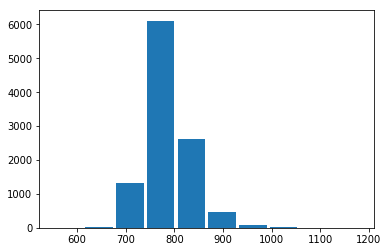

In [29]:
hist, bins = np.histogram(l2_of_all_rows)
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

In [30]:
# with norm clipping
cv = KFold(n_splits=10, random_state=1, shuffle=True)
dp_clf = dp.models.LogisticRegression(epsilon = 100,data_norm=950)
scores = cross_val_score(dp_clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: 0.636 (0.015)


#### cross validation

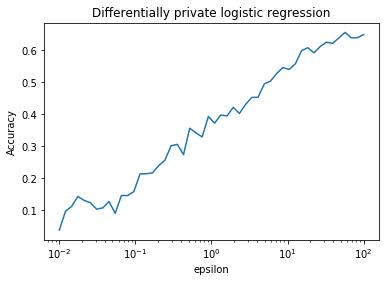

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB

epsilons = np.logspace(-2, 2, 50)
bounds = (ranges_min,ranges_max )
accuracy = list()

for epsilon in epsilons:
    clf = dp.models.LogisticRegression(epsilon = epsilon,data_norm=950)
    scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)    
    accuracy.append(mean(scores))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private logistic regression")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()

### 3.5) Random Forest

In [32]:
# this requires newer version of the library
from diffprivlib.models.forest import RandomForestClassifier



cv = KFold(n_splits=10, random_state=1, shuffle=True)
dp_clf = RandomForestClassifier(epsilon=10, n_estimators=5, random_state=1000, cat_feature_threshold=2,
                                       feature_domains=bounds_for_forest)
scores = cross_val_score(dp_clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


ModuleNotFoundError: No module named 'diffprivlib.models.forest'

## 4) Histogram Analysis
### 4.1) Age Distributoin


In [236]:
total_epsilon_budget=0.2

In [237]:
import math

math.exp( total_epsilon_budget )

1.2214027581601699

In [87]:
epsilon_per_histogram=total_epsilon_budget/14

In [88]:
epsilon_per_histogram

0.014285714285714287

In [89]:
ages=ecg_df['PatientAge']
hist, bins = np.histogram(ages)
# hist = hist / hist.sum()

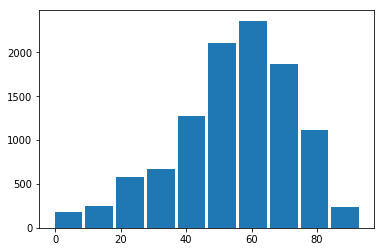

In [90]:
# actual
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

We know from the dataset description that everyone in the dataset is between 4-98 years. We should set the range tto the general bound of this attribute. we'll set the upper bound to 100, As of 2019, less than 0.005% of the world's population is aged over 100. Values above 100 will be excluded from calculations.

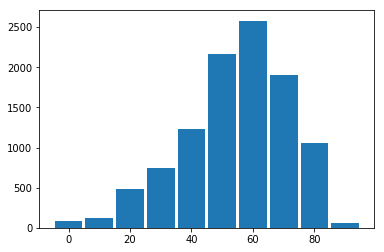

In [91]:
#diff priv histogram
dp_hist, dp_bins = dp.tools.histogram(ages, epsilon=epsilon_per_histogram, range=(0, 100))
# dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.show()

In [92]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())


Total histogram error: 1003.000000


In [93]:
np.all(dp_bins == bins)


False

### 4.2) Gender Distribution

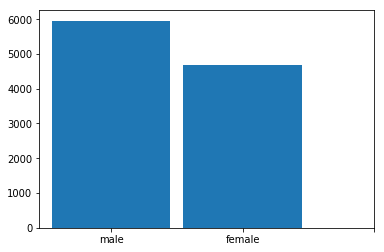

In [94]:
#actual
hist, bins = np.histogram(gender_df,bins=2)
# hist = hist / hist.sum()
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.xticks( bins, ['male','female'])
plt.show()

# categorical_features = ["male", "female"]
# gender_df.map({0: "male", 1: "female"}).value_counts().plot(kind='bar')


/anaconda3/lib/python3.7/site-packages/diffprivlib/tools/histograms.py:132: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


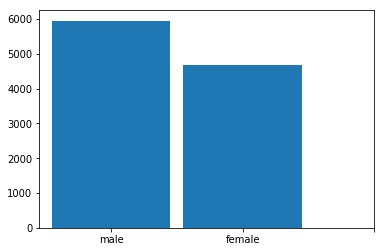

In [95]:
#diff priv
dp_hist, dp_bins = dp.tools.histogram(gender_df, epsilon=epsilon_per_histogram,bins=2)
# dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.xticks( bins, ['male','female'])

plt.show()


In [96]:
np.all(dp_bins == bins)


True

In [97]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())


Total histogram error: 32.000000


### 4.3) Finding the range of the values

In [98]:
col_names=ecg_df.columns
ranges=[]
for i in range(len(col_names)):
    ranges.append((ecg_df[ecg_df.columns[i]].min(),ecg_df[ecg_df.columns[i]].max()))

In [99]:
col_names

Index(['PatientAge', 'VentricularRate', 'AtrialRate', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset',
       'QOffset', 'TOffset', 'Gender_encoded'],
      dtype='object')

In [100]:
ranges

[(4, 98),
 (34, 263),
 (0, 535),
 (18, 256),
 (114, 736),
 (219, 760),
 (-89, 270),
 (-89, 270),
 (5, 40),
 (159, 240),
 (249, 331),
 (281, 582),
 (0, 1)]

In [101]:
VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2



### 4.4) Distribution of ECG measurment variables

##### actual Distribution

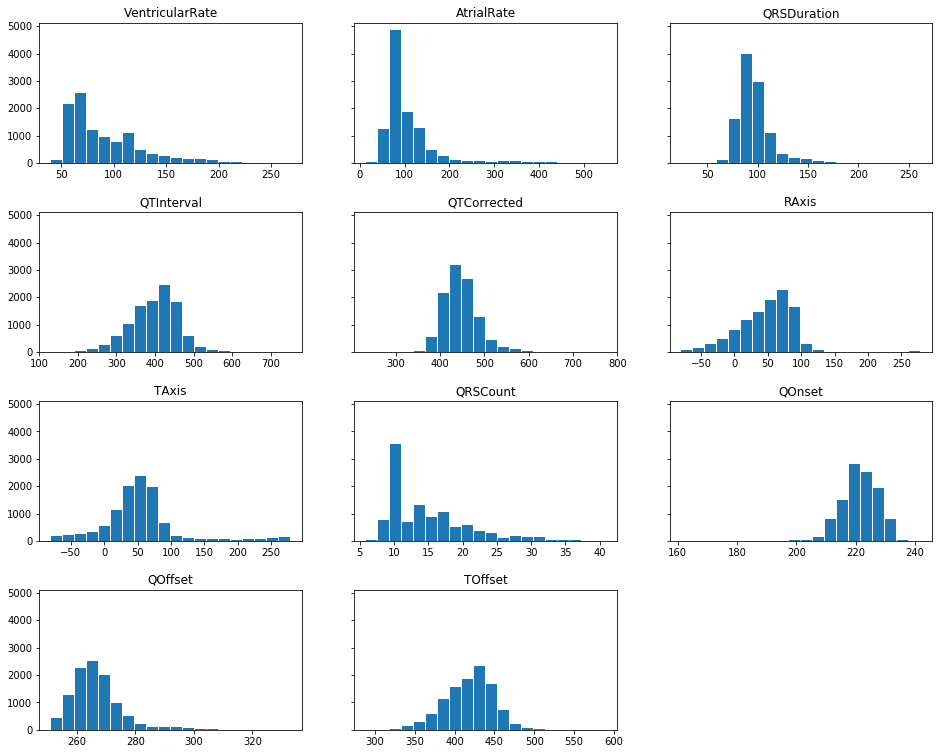

In [102]:
col_names=ecg_df.columns

n_examples = ecg_df.shape[0]

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(16, 13))
fig.subplots_adjust(hspace=0.35)

for i in range(1,12):
    ax = axs.flat[i-1]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 20
    

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = np.histogram(ecg_df.iloc[:, i], bins=n_bins, range=_range)
    ax.bar(bins[:-1] + np.diff(bins), hist , width=bar_width)
#     ax.set_ylim(0, 1)
fig.delaxes(axs[3,2])

plt.show()

#### Diff priv model

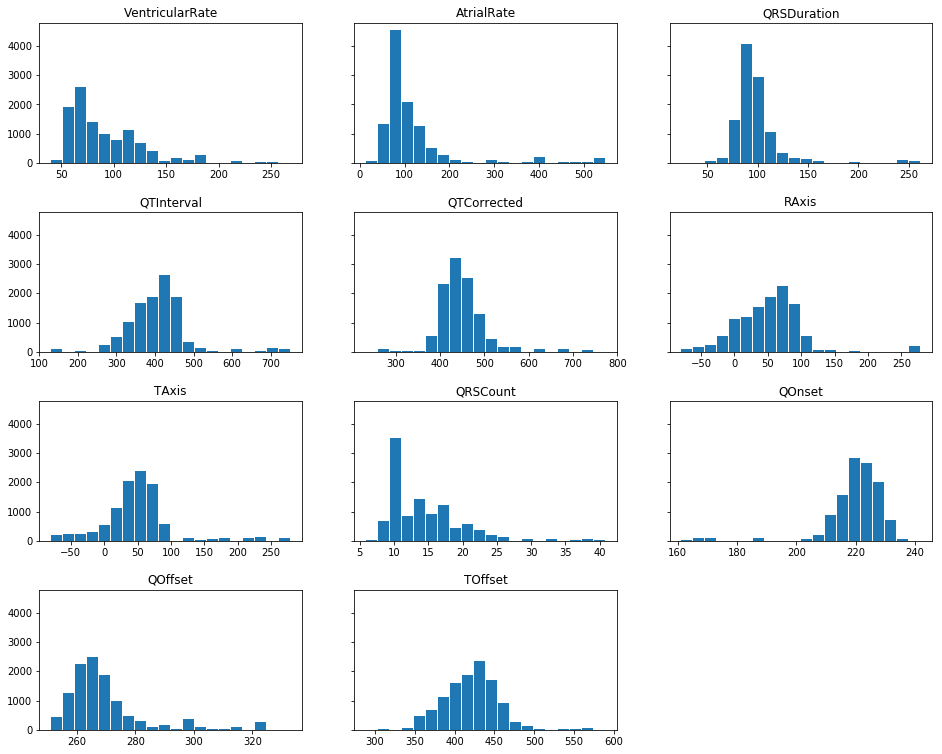

In [103]:
# ecg_df_no_gender=ecg_df.drop(['Rhythm'], axis=1)

col_names=ecg_df.columns

n_examples = ecg_df.shape[0]

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(16, 13))
fig.subplots_adjust(hspace=0.35)

for i in range(1,12):
    ax = axs.flat[i-1]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 20
    

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = dp.tools.histogram(ecg_df.iloc[:, i], bins=n_bins, range=_range, epsilon=epsilon_per_histogram)
    ax.bar(bins[:-1] + np.diff(bins), hist , width=bar_width)
#     ax.set_ylim(0, 1)
fig.delaxes(axs[3,2])
plt.show()

#### 4.5) Disease distribution

In [104]:
Y_df.unique()

array(['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT',
       'SAAWR', 'AVRT'], dtype=object)

In [105]:
Y_df_nums=Y_df.map({'AFIB':0, 'SB':1, 'SA':2, 'AF':3, 'SR':4, 'ST':5, 'SVT':6, 'AT':7, 'AVNRT':8,
       'SAAWR':9, 'AVRT':10})


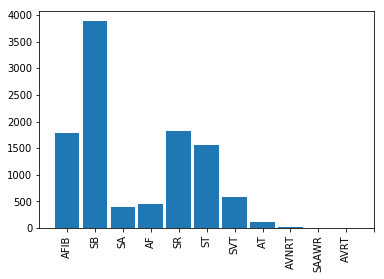

In [106]:
#actual
hist, bins = np.histogram(Y_df_nums,bins=11)
# hist = hist / hist.sum()
plt.bar(bins[:-1], hist)
plt.xticks( bins, ['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT','SAAWR', 'AVRT'], rotation='vertical')
plt.show()



plt.show()

/anaconda3/lib/python3.7/site-packages/diffprivlib/tools/histograms.py:132: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


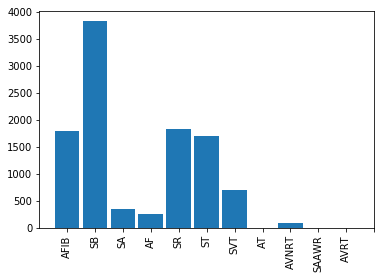

In [107]:
#difpriv

hist, bins = dp.tools.histogram(Y_df_nums, bins=11, epsilon=epsilon_per_histogram)
plt.bar(bins[:-1], hist)
plt.xticks( bins, ['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT','SAAWR', 'AVRT'], rotation='vertical')
plt.show()


## 5) Publishing A Differntially Private Report on ECG measurement differences across groups

### 5.1) Mean values report

#### 5.1.1)  Allocating the Privacy Budget

In [108]:
total_epsilon_budget=0.2

acc = dp.BudgetAccountant(total_epsilon_budget, 0)
acc.set_default()

eps_unit=total_epsilon_budget/8


VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [109]:
eps_unit

0.025

#### 5.1.2)  QRS Duration gender differences

In [110]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit*2)


95.46865928993867

In [111]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit*2)


85.20275877526821

#### Actuals

In [112]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QRSDuration_index])


95.16218938885157

In [113]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QRSDuration_index])


85.68997867803839

#### 5.1.3) Ventricular rate Duration gender differences

In [114]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,VentricularRate_index],bounds=ranges[VentricularRate_index],epsilon=eps_unit)


79.78337032587307

In [115]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,VentricularRate_index],bounds=ranges[VentricularRate_index],epsilon=eps_unit)


89.26436679309816

#### Actuals

In [116]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,VentricularRate_index])


81.26108126259234

In [117]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,VentricularRate_index])


87.78720682302772

#### 5.1.4) QTInterval  Duration gender differences

In [118]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QTInterval_index],bounds=ranges[QTInterval_index],epsilon=eps_unit)


388.2606901421914

In [119]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QTInterval_index],bounds=ranges[QTInterval_index],epsilon=eps_unit)


376.86979205603996

#### Actuals

In [120]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QTInterval_index])


386.42209536601746

In [121]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QTInterval_index])


381.26652452025587

In [122]:
acc.remaining()

(epsilon=2.2204460492503132e-17, delta=0.0)

In [123]:
acc.total

<bound method BudgetAccountant.total of BudgetAccountant(epsilon=0.2, delta=0, spent_budget=[(0.05, 0), (0.05, 0), (0.025, 0), (0.025, 0), (0.025, 0), ...])>

In [124]:
ranges[QTInterval_index]

(114, 736)

#### 5.1.5) QRS duration changes in Arrhythmias


In [125]:

VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [136]:
rhythm_fullname_mapping={'SB':'Sinus Bradycardia','SR':'Sinus Rhythm','AFIB':'Atrial Fibrillation',
                         'ST':'Sinus Tachycardia','AF':'Atrial Flutter','SA':'Sinus Irregularity',
                         'SVT':'Supraventricular Tachycardia','AT':'Atrial Tachycardia',
                         'AVNRT':'Atrioventricular Node Reentrant Tachycardia',
                         'AVRT':'Atrioventricular Reentrant Tachycardia',
                        'SAAWR':'Sinus Atrium to Atrial Wandering Rhythm'}

In [146]:
#actuals
actuals={}
for arrhytmia in arrhytmia_types:
       actuals[rhythm_fullname_mapping[arrhytmia]]=np.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index])



In [150]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{actuals[rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 92.7809\\ \hline
Sinus Bradycardia& 93.3181\\ \hline
Sinus Irregularity& 87.4536\\ \hline
Atrial Flutter& 97.2989\\ \hline
Sinus Rhythm& 87.0044\\ \hline
Sinus Tachycardia& 85.2768\\ \hline
Supraventricular Tachycardia& 96.0545\\ \hline
Atrial Tachycardia& 88.9587\\ \hline
Atrioventricular Node Reentrant Tachycardia& 89.8750\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 84.8571\\ \hline
Atrioventricular Reentrant Tachycardia& 81.5000\\ \hline


In [143]:
dp_means=[]
num_of_runs=2
for i in range(num_of_runs):
    total_epsilon_budget=0.2
    acc = dp.BudgetAccountant(total_epsilon_budget, 0)
    acc.set_default()
    eps_unit=total_epsilon_budget/11
    run={}
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        run[rhythm_fullname_mapping[arrhytmia]]=dp.tools.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)
    dp_means.append(run)
        
        

    

In [151]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{dp_means[0][rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{dp_means[1][rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 100.3062& 81.6582\\ \hline
Sinus Bradycardia& 93.4313& 92.2033\\ \hline
Sinus Irregularity& 18.0000& 145.1477\\ \hline
Atrial Flutter& 127.7923& 176.5641\\ \hline
Sinus Rhythm& 87.8604& 92.4898\\ \hline
Sinus Tachycardia& 76.0064& 87.0250\\ \hline
Supraventricular Tachycardia& 85.7767& 96.3541\\ \hline
Atrial Tachycardia& 52.0237& 18.0000\\ \hline
Atrioventricular Node Reentrant Tachycardia& 18.0000& 256.0000\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 256.0000& 256.0000\\ \hline
Atrioventricular Reentrant Tachycardia& 120.5715& 256.0000\\ \hline


In [130]:
acc.remaining()[0]

0.018181818181818167

#### 5.1.6) Approximate Differential privacy (epsilon+ delta)  

In [1]:
total_delta=1
delta_slack=1/(100*10646)#this delta value guarntees that 99% leak wont happen for each user due to addition of delta
print(f"delta: {delta_slack}")

approx_dp_means=[]
num_of_runs=2
for i in range(num_of_runs):
    total_epsilon_budget=0.2
    acc = dp.BudgetAccountant(epsilon=total_epsilon_budget, delta=total_delta,slack=delta_slack)
    acc.set_default()
    eps_unit=total_epsilon_budget/11
    
    run={}
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        run[rhythm_fullname_mapping[arrhytmia]]=dp.tools.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)
    approx_dp_means.append(run)


delta: 9.393199323689648e-07


NameError: name 'dp' is not defined

In [234]:
acc.remaining()

(epsilon=1.1102230246251566e-17, delta=1.0)

In [216]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{approx_dp_means[0][rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{approx_dp_means[1][rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 105.8062& 92.4601\\ \hline
Sinus Bradycardia& 92.5342& 93.3452\\ \hline
Sinus Irregularity& 59.4757& 117.9870\\ \hline
Atrial Flutter& 90.3509& 96.0809\\ \hline
Sinus Rhythm& 88.8872& 94.3970\\ \hline
Sinus Tachycardia& 96.1214& 99.5332\\ \hline
Supraventricular Tachycardia& 96.0013& 94.5605\\ \hline
Atrial Tachycardia& 254.1035& 48.8832\\ \hline
Atrioventricular Node Reentrant Tachycardia& 18.0000& 28.6774\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 256.0000& 81.9996\\ \hline
Atrioventricular Reentrant Tachycardia& 18.0000& 256.0000\\ \hline


In [126]:
acc.remaining()

(epsilon=1.2212453270876722e-17, delta=0.0010000000000000009)

#### mean values per age group

In [48]:
#FEMALE
num_of_runs=3
for i in range(num_of_runs):
    total_epsilon_budget=0.11
    acc = dp.BudgetAccountant(total_epsilon_budget, 0)
    acc.set_default()

    eps_unit=total_epsilon_budget/11
    ecg_df_female=ecg_df[ecg_df['Gender_encoded']==1]
    print(f'************run: {i+1}**************')
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        print(arrhytmia)
        print('actual: '+str(np.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index])))
        print('dp: '+str (dp.tools.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))


************run: 1**************
AFIB
actual: 88.70906630581868
dp: 173.78739507409924
SB
actual: 86.94460227272727
dp: 81.43274064609611
SA
actual: 82.42045454545455
dp: 18.0
AF
actual: 91.44680851063829
dp: 256.0
SR
actual: 82.943359375
dp: 71.64847603639979
ST
actual: 81.14434330299089
dp: 18.0
SVT
actual: 91.8961038961039
dp: 18.0
AT
actual: 83.05263157894737
dp: 18.0
AVNRT
actual: 91.16666666666667
dp: 18.0
SAAWR
actual: 84.0
dp: 256.0
AVRT
actual: 81.33333333333333
dp: 256.0
************run: 2**************
AFIB
actual: 88.70906630581868
dp: 69.25205247411296
SB
actual: 86.94460227272727
dp: 96.8015710610814
SA
actual: 82.42045454545455
dp: 18.0
AF
actual: 91.44680851063829
dp: 256.0
SR
actual: 82.943359375
dp: 40.74844250146039
ST
actual: 81.14434330299089
dp: 55.26487940632792
SVT
actual: 91.8961038961039
dp: 136.85261354433663
AT
actual: 83.05263157894737
dp: 18.0
AVNRT
actual: 91.16666666666667
dp: 18.0
SAAWR
actual: 84.0
dp: 256.0
AVRT
actual: 81.33333333333333
dp: 256.0
***

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [49]:
#MALE
num_of_runs=3
for i in range(num_of_runs):
    total_epsilon_budget=0.11
    acc = dp.BudgetAccountant(total_epsilon_budget, 0)
    acc.set_default()

    eps_unit=total_epsilon_budget/11
    ecg_df_female=ecg_df[ecg_df['Gender_encoded']==0]
    print(f'************run: {i+1}**************')
    for arrhytmia in arrhytmia_types:
        print(arrhytmia)
        print('actual: '+str(np.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index])))
        print('dp: '+str (dp.tools.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))


************run: 1**************
AFIB
actual: 95.67146974063401
dp: 101.50531950523555
SB
actual: 96.93510681176944
dp: 106.17928769919682
SA
actual: 91.42600896860986
dp: 28.786219617769888
AF
actual: 101.57976653696498
dp: 184.89255007114696
SR
actual: 92.18952618453865
dp: 80.72648489337175
ST
actual: 89.2540675844806
dp: 114.05775549529294
SVT
actual: 100.64516129032258
dp: 98.74118713807574
AT
actual: 94.21875
dp: 36.62638174378238
AVNRT
actual: 86.0
dp: 18.0
SAAWR
actual: 90.0
dp: 18.0
AVRT
actual: 81.6
dp: 18.0
************run: 2**************
AFIB
actual: 95.67146974063401
dp: 103.12256888165065
SB
actual: 96.93510681176944
dp: 108.24015095055397
SA
actual: 91.42600896860986
dp: 101.00768932396096
AF
actual: 101.57976653696498
dp: 18.0
SR
actual: 92.18952618453865
dp: 131.2911691327608
ST
actual: 89.2540675844806
dp: 75.28702395816379
SVT
actual: 100.64516129032258
dp: 65.47972375744398
AT
actual: 94.21875
dp: 256.0
AVNRT
actual: 86.0
dp: 18.0
SAAWR
actual: 90.0
dp: 256.0
AVRT


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### 5.2)  Median Values Report

In [220]:
#actuals
median_actuals={}
for arrhytmia in arrhytmia_types:
       median_actuals[rhythm_fullname_mapping[arrhytmia]]=np.median(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index])

        

In [221]:
dp_medians=[]
num_of_runs=2
for i in range(num_of_runs):
    total_epsilon_budget=0.2
    acc = dp.BudgetAccountant(epsilon=total_epsilon_budget)
    acc.set_default()
    eps_unit=total_epsilon_budget/11
    
    run={}
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        run[rhythm_fullname_mapping[arrhytmia]]=dp.tools.median(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)
    dp_medians.append(run)





In [62]:
acc.remaining()

(epsilon=1.2212453270876722e-17, delta=0.0)

In [222]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{median_actuals[rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{dp_medians[0][rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{dp_medians[1][rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 88.0000& 89.8094& 89.3675\\ \hline
Sinus Bradycardia& 92.0000& 91.6741& 88.3865\\ \hline
Sinus Irregularity& 86.0000& 216.8734& 87.1713\\ \hline
Atrial Flutter& 90.0000& 219.0696& 183.2532\\ \hline
Sinus Rhythm& 86.0000& 84.1707& 87.1782\\ \hline
Sinus Tachycardia& 82.0000& 81.1739& 85.6976\\ \hline
Supraventricular Tachycardia& 84.0000& 83.7181& 99.5226\\ \hline
Atrial Tachycardia& 86.0000& 75.9621& 79.5899\\ \hline
Atrioventricular Node Reentrant Tachycardia& 82.0000& 170.2546& 203.1612\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 90.0000& 44.5616& 80.2591\\ \hline
Atrioventricular Reentrant Tachycardia& 78.0000& 255.0393& 126.6465\\ \hline
